# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 10000-100000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 


In [78]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 15:11:03.696051
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [79]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=10000
MAXLEN=100000   

In [80]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [81]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [82]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [83]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [84]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 15:11:06.737813
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 15:11:06.769187
Load sequence...
2022-12-29 15:11:30.758785
Num IDs: 993
Example IDs: [('ENSG00000133216', 'ENST00000374630.8'), ('ENSG00000127603', 'ENST00000372915.8'), ('ENSG00000162402', 'ENST00000294383.7'), ('ENSG00000134245', 'ENST00000369684.5')]
Count 256 ones out of 993 labels.
Example labels: [0, 0, 0, 0]
Num counts: 993
Example sequence: [163, 139, 41, 161, 129, 2, 7, 26, 102, 151, 90, 103, 154, 101, 147, 74, 39, 154, 102, 151, 91, 107, 170, 168, 159, 123, 235, 171, 170, 167, 155, 107, 170, 167, 155, 106, 166, 150, 87, 91, 107, 169, 162, 133, 18, 70, 23, 89, 98, 133, 19, 73, 36, 144, 64, 256, 256, 254, 248, 223, 124, 239, 185, 226, 134, 21, 84, 79, 57, 225, 129, 3, 9, 35, 137, 35, 137, 33, 129, 4, 13, 49, 193, 3, 9, 33, 132, 15, 57, 228, 142, 54, 213, 84, 79, 57, 228, 144, 64, 254, 248, 

## Model

In [85]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [86]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 15:11:31.384497
COMPILE
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 99997, 4)          1028      
                                                                 
 conv1d_42 (Conv1D)          (None, 99990, 64)         2112      
                                                                 
 global_average_pooling1d_42  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_85 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [87]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 15:11:31.614243
2022-12-29 15:11:31.614872
splitting
Fold 1
Training example
[ 47 188 239 ...   0   0   0]
Train sizes (800, 99997) (800, 1)
Valid sizes (193, 99997) (193, 1)
Train set ones/size 209 / 800
Valid set ones/size 47 / 193
BUILD MODEL
COMPILE
FIT
2022-12-29 15:11:37.327239
Epoch 1/5
25/25 [==============================] - 4s 117ms/step - loss: 0.6492 - accuracy: 0.7387 - val_loss: 0.5909 - val_accuracy: 0.7565
Epoch 2/5
25/25 [==============================] - 3s 108ms/step - loss: 0.5769 - accuracy: 0.7387 - val_loss: 0.5544 - val_accuracy: 0.7565
Epoch 3/5
25/25 [==============================] - 3s 108ms/step - loss: 0.5748 - accuracy: 0.7387 - val_loss: 0.5535 - val_accuracy: 0.7565
Epoch 4/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5723 - accuracy: 0.7387 - val_loss: 0.5544 - val_accuracy: 0.7565
Epoch 5/5
25/25 [==============================] - 3s 109ms/step - loss: 0.5714 - accuracy: 0.7387 - val_loss: 0.5511 - val_accuracy: 0.7565

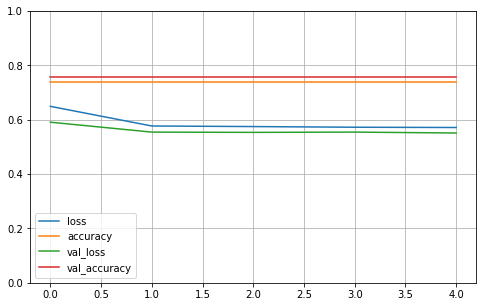

Compute valiation accuracy
2022-12-29 15:11:58.820098
Range of scores: 0.23488548 to 0.26121005
Predicted zeros and ones 193 0
Accuracy: 75.65% Precision: 0.00% Recall: 0.00% F1: 0.00%
2022-12-29 15:11:59.291239
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 47 188 239 ...   0   0   0]
Train sizes (768, 99997) (768, 1)
Valid sizes (225, 99997) (225, 1)
Train set ones/size 184 / 768
Valid set ones/size 72 / 225
BUILD MODEL
COMPILE
FIT
2022-12-29 15:12:04.907174
Epoch 1/5
24/24 [==============================] - 4s 128ms/step - loss: 0.6458 - accuracy: 0.7604 - val_loss: 0.6327 - val_accuracy: 0.6800
Epoch 2/5
24/24 [==============================] - 3s 111ms/step - loss: 0.5576 - accuracy: 0.7604 - val_loss: 0.6522 - val_accuracy: 0.6800
Epoch 3/5
24/24 [==============================] - 3s 110ms/step - loss: 0.5510 - accuracy: 0.7604 - val_loss: 0.6468 - val_accuracy: 0.6800
Epoch 4/5
24/24 [==============================] - 3s 112ms/step - loss: 0.5496 - accuracy: 0.7604 - val_loss: 0.6381 - val_accuracy: 0.6800
Epoch 5/5
24/24 [==============================] - 3s 111ms/step - loss: 0.5496 - accuracy: 0.7604 - val_loss: 0.6409 - val_accuracy: 0.6800


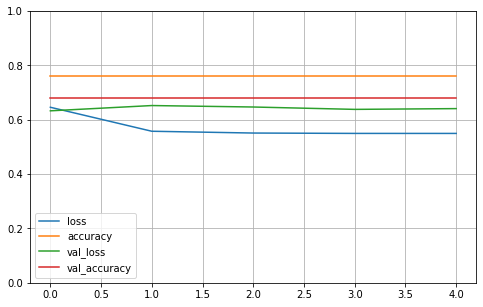

Compute valiation accuracy
2022-12-29 15:12:19.524374
Range of scores: 0.21616407 to 0.2433991
Predicted zeros and ones 225 0
Accuracy: 68.00% Precision: 0.00% Recall: 0.00% F1: 0.00%
2022-12-29 15:12:20.010993
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 47 188 239 ...   0   0   0]
Train sizes (787, 99997) (787, 1)
Valid sizes (206, 99997) (206, 1)
Train set ones/size 208 / 787
Valid set ones/size 48 / 206
BUILD MODEL
COMPILE
FIT
2022-12-29 15:12:25.585324
Epoch 1/5
25/25 [==============================] - 4s 124ms/step - loss: 0.6396 - accuracy: 0.7357 - val_loss: 0.5711 - val_accuracy: 0.7670
Epoch 2/5
25/25 [==============================] - 3s 106ms/step - loss: 0.5804 - accuracy: 0.7357 - val_loss: 0.5442 - val_accuracy: 0.7670
Epoch 3/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5768 - accuracy: 0.7357 - val_loss: 0.5444 - val_accuracy: 0.7670
Epoch 4/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5752 - accuracy: 0.7357 - val_loss: 0.5450 - val_accuracy: 0.7670
Epoch 5/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5747 - accuracy: 0.7357 - val_loss: 0.5441 - val_accuracy: 0.7670


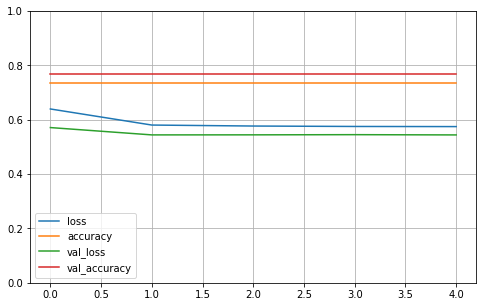

Compute valiation accuracy
2022-12-29 15:12:40.652987
Range of scores: 0.2571914 to 0.31736484
Predicted zeros and ones 206 0
Accuracy: 76.70% Precision: 0.00% Recall: 0.00% F1: 0.00%
2022-12-29 15:12:41.091997
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[121 227 138 ...   0   0   0]
Train sizes (789, 99997) (789, 1)
Valid sizes (204, 99997) (204, 1)
Train set ones/size 212 / 789
Valid set ones/size 44 / 204
BUILD MODEL
COMPILE
FIT
2022-12-29 15:12:47.276808
Epoch 1/5
25/25 [==============================] - 4s 127ms/step - loss: 0.6538 - accuracy: 0.7009 - val_loss: 0.5794 - val_accuracy: 0.7843
Epoch 2/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5897 - accuracy: 0.7313 - val_loss: 0.5234 - val_accuracy: 0.7843
Epoch 3/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5815 - accuracy: 0.7313 - val_loss: 0.5266 - val_accuracy: 0.7843
Epoch 4/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5806 - accuracy: 0.7313 - val_loss: 0.5274 - val_accuracy: 0.7843
Epoch 5/5
25/25 [==============================] - 3s 107ms/step - loss: 0.5802 - accuracy: 0.7313 - val_loss: 0.5242 - val_accuracy: 0.7843


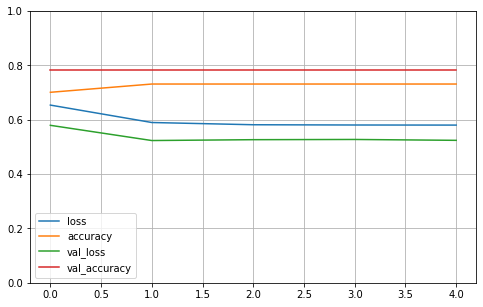

Compute valiation accuracy
2022-12-29 15:13:02.142323
Range of scores: 0.25501478 to 0.2880173
Predicted zeros and ones 204 0
Accuracy: 78.43% Precision: 0.00% Recall: 0.00% F1: 0.00%
2022-12-29 15:13:02.621881
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 47 188 239 ...   0   0   0]
Train sizes (828, 99997) (828, 1)
Valid sizes (165, 99997) (165, 1)
Train set ones/size 211 / 828
Valid set ones/size 45 / 165
BUILD MODEL
COMPILE
FIT
2022-12-29 15:13:08.306610
Epoch 1/5
26/26 [==============================] - 4s 124ms/step - loss: 0.6339 - accuracy: 0.7452 - val_loss: 0.5954 - val_accuracy: 0.7273
Epoch 2/5
26/26 [==============================] - 3s 106ms/step - loss: 0.5710 - accuracy: 0.7452 - val_loss: 0.5908 - val_accuracy: 0.7273
Epoch 3/5
26/26 [==============================] - 3s 106ms/step - loss: 0.5664 - accuracy: 0.7452 - val_loss: 0.5860 - val_accuracy: 0.7273
Epoch 4/5
26/26 [==============================] - 3s 106ms/step - loss: 0.5677 - accuracy: 0.7452 - val_loss: 0.5862 - val_accuracy: 0.7273
Epoch 5/5
26/26 [==============================] - 3s 105ms/step - loss: 0.5649 - accuracy: 0.7452 - val_loss: 0.5842 - val_accuracy: 0.7273


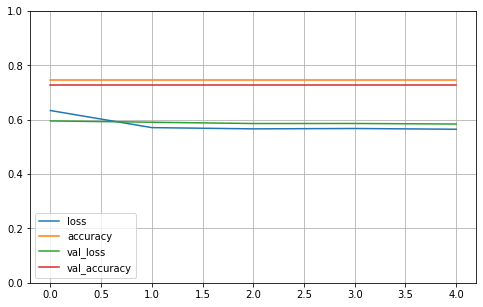

Compute valiation accuracy
2022-12-29 15:13:23.874238
Range of scores: 0.24257651 to 0.2769428
Predicted zeros and ones 165 0
Accuracy: 72.73% Precision: 0.00% Recall: 0.00% F1: 0.00%
2022-12-29 15:13:24.249293

Cross validation 5 folds 5 epochs
 accuracy mean 74.30% +/- 3.66
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2022-12-29 15:13:24.257527


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())